### Import libraries

In [31]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import hydra
from omegaconf import OmegaConf
import optuna
from plotly.offline import iplot
import plotly.graph_objs as go

# device setup
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: mps


### Utility functions

In [32]:
def rmse(y_true, y_pred):
    y_true_var = np.exp(2 * y_true)
    y_pred_var = np.exp(2 * y_pred)
    return float(np.sqrt(np.mean((y_true_var - y_pred_var) ** 2)))

def qlike(y_true, y_pred, eps=1e-12):
    y_true_var = np.exp(2 * y_true)
    y_pred_var = np.exp(2 * y_pred)
    ratio = (y_true_var + eps) / (y_pred_var + eps)
    return float(np.mean(ratio - np.log(ratio) - 1.0))

def calculate_metrics(df):
    return {'rmse' : rmse(df.value.values, df.prediction.values),
           'qlike' : qlike(df.value.values, df.prediction.values)
           }

def plot_predictions(df_result):
    data = []
    value = go.Scatter(
        x=df_result.index,
        y=df_result.value,
        mode="lines",
        name="values",
        line=dict(color="rgba(0,0,0,0.3)")
    )
    data.append(value)
    prediction = go.Scatter(
        x=df_result.index,
        y=df_result.prediction,
        mode="lines",
        line={"dash": "dot"},
        name='predictions',
        opacity=0.8
    )
    data.append(prediction)
    layout = dict(
        title="Predictions vs Actual Values for the dataset",
        xaxis=dict(title="Time"),
        yaxis=dict(title="Value")
    )
    fig = dict(data=data, layout=layout)
    iplot(fig)

def inverse_transform_y(scaler_y, arr):
    inv = scaler_y.inverse_transform(arr.reshape(-1,1)).ravel()
    return inv

def format_predictions(predictions, values, df_test_index, scaler_y):
    if isinstance(predictions, list):
        preds_arr = np.concatenate([p.reshape(-1) for p in predictions], axis=0)
    else:
        preds_arr = np.array(predictions).reshape(-1)

    vals_arr = np.concatenate([v.reshape(-1) for v in values], axis=0)

    preds_inv = inverse_transform_y(scaler_y, preds_arr)
    vals_inv = inverse_transform_y(scaler_y, vals_arr)

    n = min(len(vals_inv), len(preds_inv), len(df_test_index))
    idx = df_test_index[:n]

    df_result = pd.DataFrame(data={"value": vals_inv[:n], "prediction": preds_inv[:n]}, index=idx)
    df_result = df_result.sort_index()
    return df_result

### Load dataset

In [33]:
df = pd.read_csv("../Data/btc_final_df.csv")
df = df.rename(columns={'vol_future': 'value'})
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index(['timestamp'])
df.fillna(0, inplace=True)
df.head()

,btc_exchange_netflow_usd,active_sending_addresses,active_receiving_addresses,onchain_volume_usd,open,low,high,close,mint_reward_usd,total_fee_usd,...,value,whale_net_usd,whale_net_usd_24h,whale_burst_flag,etow_usd_log,etow_coins_log,whale_txn_count_log,wtoe_usd_log,wtoe_coins_log,eth_to_btc_spill
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-11-05 00:00:00+00:00,-6.662422e+07,19980.0,31653.0,0.592267,67874.04,67726.42,68101.90,67984.55,8.497363e+05,-0.010698,...,-4.859671,-53625145,65422718.0,1,17.797529,6.665684,-0.606516,0.0,0.0,0.0
2024-11-05 01:00:00+00:00,1.639840e+06,10421.0,16253.0,-2.226320,68040.42,67517.08,68063.82,67930.69,4.251372e+05,-1.671009,...,-5.114447,-53625145,65422718.0,1,17.797529,6.665684,-0.606516,0.0,0.0,0.0
2024-11-05 02:00:00+00:00,-8.418988e+06,32446.0,49217.0,-0.145964,67971.14,67801.24,68007.02,67860.73,1.486316e+06,0.204168,...,-5.298419,-53625145,65422718.0,1,17.797529,6.665684,-0.606516,0.0,0.0,0.0
2024-11-05 03:00:00+00:00,9.149680e+06,14226.0,26882.0,-0.894823,67888.40,67815.46,68158.94,68158.94,6.379559e+05,-0.656228,...,-4.893300,-53625145,65422718.0,1,17.797529,6.665684,-0.606516,0.0,0.0,0.0
2024-11-05 04:00:00+00:00,-7.860233e+07,33326.0,34409.0,-0.011322,68211.29,68115.09,68436.16,68265.49,1.708395e+06,-0.304570,...,-4.780499,-53625145,65422718.0,1,17.797529,6.665684,-0.606516,0.0,0.0,0.0


### Dataloaders functions

In [34]:
def make_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size, seq_length):
    def create_sequences(X, y, seq_length):
        X_seq, y_seq = [], []
        for i in range(len(X) - seq_length):
            X_seq.append(X[i:i+seq_length].values)
            y_seq.append(y.iloc[i+seq_length].values)
        return np.array(X_seq), np.array(y_seq)

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_train_arr = scaler_x.fit_transform(X_train)
    X_val_arr = scaler_x.transform(X_val)
    X_test_arr = scaler_x.transform(X_test)
    y_train_arr = scaler_y.fit_transform(y_train)
    y_val_arr = scaler_y.transform(y_val)
    y_test_arr = scaler_y.transform(y_test)

    X_train_seq, y_train_seq = create_sequences(pd.DataFrame(X_train_arr), pd.DataFrame(y_train_arr), seq_length)
    X_val_seq, y_val_seq = create_sequences(pd.DataFrame(X_val_arr), pd.DataFrame(y_val_arr), seq_length)
    X_test_seq, y_test_seq = create_sequences(pd.DataFrame(X_test_arr), pd.DataFrame(y_test_arr), seq_length)

    train = TensorDataset(torch.Tensor(X_train_seq), torch.Tensor(y_train_seq))
    val = TensorDataset(torch.Tensor(X_val_seq), torch.Tensor(y_val_seq))
    test = TensorDataset(torch.Tensor(X_test_seq), torch.Tensor(y_test_seq))

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
    return train_loader, val_loader, test_loader, scaler_x, scaler_y

def make_final_dataloaders(X_train, X_test, y_train, y_test, batch_size):
    scaler_x = MinMaxScaler()
    X_train_arr = scaler_x.fit_transform(X_train)
    X_test_arr = scaler_x.transform(X_test)
    scaler_y = MinMaxScaler()
    y_train_arr = scaler_y.fit_transform(y_train)
    y_test_arr = scaler_y.transform(y_test)

    train = TensorDataset(torch.Tensor(X_train_arr), torch.Tensor(y_train_arr))
    test = TensorDataset(torch.Tensor(X_test_arr), torch.Tensor(y_test_arr))

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)
    return train_loader, test_loader, test_loader_one, scaler_x, scaler_y



### Data split functions

In [35]:
def time_series_train_test_split(df, train_size=0.85, purge_hours=1):
    n = len(df)
    train_end = int(n * train_size)
    purge = int(purge_hours)
    train = df.iloc[:train_end].copy()
    test = df.iloc[train_end + purge :].copy()
    return train, test

def rolling_splits_with_val(df, target_col, n_splits=5, purge_hours=1, val_ratio=0.15, test_size=120):
    df = df.sort_index()
    X = df.drop(columns=[target_col])
    y = df[[target_col]]

    n = len(df)
    train_size = n - (purge_hours + n_splits * test_size)
    if train_size <= 0:
        raise ValueError("Not enough data for given n_splits, purge_hours, and test_size.")

    splits = []
    start_train = 0
    for k in range(n_splits):
        end_train = start_train + train_size
        start_test = end_train + purge_hours
        end_test = start_test + test_size
        if end_test > n: break

        val_size = max(1, int(train_size * val_ratio))
        train_cut = end_train - val_size

        train_idx = np.arange(start_train, train_cut)
        val_idx = np.arange(train_cut, end_train)
        test_idx = np.arange(start_test, end_test)

        X_train, y_train = X.iloc[train_idx].copy(), y.iloc[train_idx].copy()
        X_val, y_val = X.iloc[val_idx].copy(), y.iloc[val_idx].copy()
        X_test, y_test = X.iloc[test_idx].copy(), y.iloc[test_idx].copy()
        splits.append((X_train, X_val, X_test, y_train, y_val, y_test))
        start_train += test_size

    return splits

### LSTM model

In [36]:
class LSTMModel(pl.LightningModule):
    def __init__(self, loss_fn, input_dim=1, hidden_dim=64, layer_dim=2,
                 output_dim=1, dropout=0.1, learning_rate=1e-4, weight_decay=1e-6):
        super().__init__()
        self.loss_fn = loss_fn
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.dropout = dropout
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.save_hyperparameters()

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        batch_size = x.size(0)
        h0 = torch.zeros(self.layer_dim, batch_size, self.hidden_dim, device=x.device)
        c0 = torch.zeros(self.layer_dim, batch_size, self.hidden_dim, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        pred = self.forward(x)
        mse_loss = nn.MSELoss()(pred, y)
        self.log('train_loss', torch.sqrt(mse_loss))
        return mse_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)
        pred = self.forward(x)
        rmse_loss = torch.sqrt(nn.MSELoss()(pred, y))
        self.log('val_loss', rmse_loss)
        return rmse_loss

    def predict_step(self, batch, batch_idx):
        x, _ = batch
        x = x.to(self.device)
        return self.forward(x).detach().cpu().numpy()

In [37]:
@hydra.main(version_base=None, config_path=None, config_name=None)
def main(cfg):
    mode = cfg.mode.lower()

    if mode == "tune":
        def objective(trial):
            hidden_dim = trial.suggest_categorical("hidden_dim", [16, 32, 64])
            layer_dim = trial.suggest_categorical("layer_dim", [1, 2])
            dropout = trial.suggest_float("dropout", 0.1, 0.3)
            batch_size = trial.suggest_categorical("batch_size", [4, 8])
            seq_length = trial.suggest_categorical("seq_length", [1,2,3,4,5,6])

            train_df, test_df = time_series_train_test_split(df, train_size=cfg.train_size, purge_hours=cfg.purge_hours)
            splits = rolling_splits_with_val(train_df, cfg.target_col, n_splits=cfg.n_splits,
                                             purge_hours=cfg.purge_hours, val_ratio=cfg.val_ratio)

            val_losses = []
            for X_train, X_val, X_test, y_train, y_val, y_test in splits:
                train_loader, val_loader, _, _, scaler_y = make_dataloaders(
                    X_train, X_val, X_test, y_train, y_val, y_test, batch_size, seq_length
                )
                model = LSTMModel(nn.MSELoss(), input_dim=X_train.shape[1],
                                  hidden_dim=hidden_dim, layer_dim=layer_dim, dropout=dropout)
                trainer = pl.Trainer(max_epochs=cfg.n_epochs, accelerator="auto", devices=1,
                                     callbacks=[EarlyStopping(monitor="val_loss", patience=cfg.patience)],
                                     logger=False, enable_progress_bar=False, enable_checkpointing=False)
                trainer.fit(model, train_loader, val_loader)
                preds = trainer.predict(model, dataloaders=val_loader)
                vals = [y.numpy() for _, y in val_loader]
                df_val_result = format_predictions(preds, vals, X_val.index, scaler_y)
                val_rmse = rmse(df_val_result.value.values, df_val_result.prediction.values)
                val_losses.append(val_rmse)

            return float(np.mean(val_losses))

        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=cfg.n_trials)
        print("Best hyperparameters:", study.best_params)
        return study.best_params

    elif mode == "final":
        best_params = cfg.best_params
        df_train, df_test = time_series_train_test_split(df, train_size=cfg.train_size, purge_hours=cfg.purge_hours)

        X_train_final = df_train.drop(columns=[cfg.target_col]).sort_index()
        y_train_final = df_train[[cfg.target_col]].sort_index()
        X_test = df_test.drop(columns=[cfg.target_col])
        y_test = df_test[[cfg.target_col]]

        train_loader, test_loader, test_loader_one, scaler_X, scaler_y = make_final_dataloaders(
            X_train_final, X_test, y_train_final, y_test, best_params["batch_size"]
        )

        model = LSTMModel(nn.MSELoss(), input_dim=X_train_final.shape[1],
                          hidden_dim=best_params["hidden_dim"],
                          layer_dim=best_params["layer_dim"],
                          dropout=best_params["dropout"])

        trainer = pl.Trainer(max_epochs=cfg.n_epochs, accelerator="auto", devices=1,
                             callbacks=[], logger=False, enable_progress_bar=False,
                             enable_checkpointing=False)
        trainer.fit(model, train_loader)

        preds = trainer.predict(model, dataloaders=test_loader_one)
        values = [y.numpy() for _, y in test_loader_one]

        df_result = format_predictions(preds, values, X_test.index, scaler_y)
        metrics = calculate_metrics(df_result)
        print(f"\nFinal Evaluation Metrics:")
        print(f"  RMSE  = {metrics['rmse']:.6f}")
        print(f"  QLIKE = {metrics['qlike']:.6f}")

        plot_predictions(df_result)

        # Captum feature importance
        from captum.attr import IntegratedGradients

        def compute_feature_importance_captum(model, dataloader, feature_names):
            model.eval()
            ig = IntegratedGradients(model)
            all_attr = []

            for batch in dataloader:
                inputs, _ = batch
                inputs = inputs.to(model.device)
                if len(inputs.shape) == 2:
                    inputs = inputs.unsqueeze(1)
                attributions, _ = ig.attribute(inputs, target=None, return_convergence_delta=True)
                all_attr.append(attributions.detach().cpu().numpy())

            attr_array = np.concatenate(all_attr, axis=0)
            avg_attr = np.mean(np.abs(attr_array), axis=(0, 1))
            feature_importance = pd.DataFrame({
                "feature": feature_names,
                "importance": avg_attr / np.sum(avg_attr)
            }).sort_values("importance", ascending=False)
            return feature_importance

        feature_names = list(X_test.columns)
        feature_importance = compute_feature_importance_captum(model, test_loader, feature_names)
        print("\nFeature Importance (Integrated Gradients):")
        print(feature_importance)

        return df_result, metrics, feature_importance

    else:
        raise ValueError("Unknown mode. Choose 'tune' or 'final'.")

### Run tuning, final evaluation and feature importance

In [38]:
# hyperparameter tuning
cfg_tune = OmegaConf.create({
    "mode": "tune",
    "target_col": "value",
    "train_size": 0.85,
    "purge_hours": 1,
    "val_ratio": 0.15,
    "n_splits": 5,
    "test_size": 120,
    "n_trials": 5,
    "n_epochs": 20,
    "patience": 5
})
best_params = main(cfg_tune)

# Final evaluation
cfg_final = OmegaConf.create({
    "mode": "final",
    "target_col": "value",
    "train_size": 0.85,
    "purge_hours": 1,
    "best_params": best_params,
    "n_epochs": 20
})
preds_concat, metrics, feature_importance = main(cfg_final)


[I 2025-11-03 23:31:52,016] A new study created in memory with name: no-name-21285bc3-0852-4847-b66e-3b0f18b3ffd1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lstm    | LSTM    | 7.7 K  | train
2 | fc      | Linear  | 33     | train
--------------------------------------------
7.7 K     Trainable params
0         Non-trainable params
7.7 K     Total params
0.031     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | lstm    | LSTM    | 7.7 K  | train
2 | f

Best hyperparameters: {'hidden_dim': 32, 'layer_dim': 1, 'dropout': 0.2816575833593924, 'batch_size': 8, 'seq_length': 1}


`Trainer.fit` stopped: `max_epochs=20` reached.



Final Evaluation Metrics:
  RMSE  = 0.000711
  QLIKE = 1.420040



Feature Importance (Integrated Gradients):
                       feature  importance
13                   RV_MA_1hr    0.134988
14                   RV_MA_3hr    0.128012
15                  RV_MA_12hr    0.126690
17               whale_net_usd    0.092440
5                          low    0.091046
16               hourly_return    0.078591
4                         open    0.072433
0     btc_exchange_netflow_usd    0.050932
7                        close    0.042326
9                total_fee_usd    0.037476
3           onchain_volume_usd    0.025477
2   active_receiving_addresses    0.024835
11      exchange_to_wallet_usd    0.016058
8              mint_reward_usd    0.010177
23                wtoe_usd_log    0.010161
24              wtoe_coins_log    0.009309
1     active_sending_addresses    0.009083
21              etow_coins_log    0.008222
18           whale_net_usd_24h    0.007756
10           transaction_count    0.006979
12      wallet_to_exchange_usd    0.006067
6         

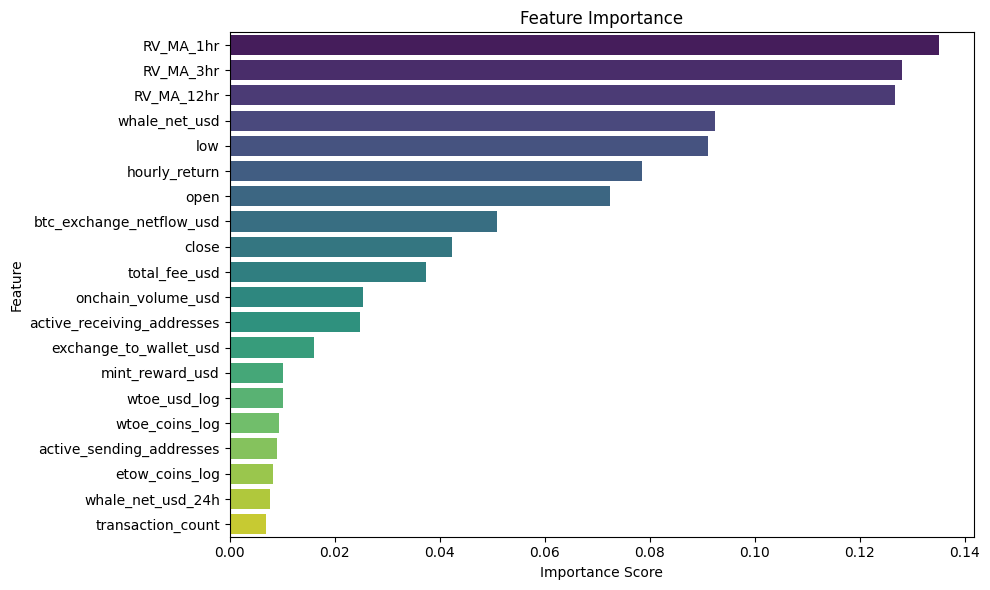

In [39]:
feature_importance_df = pd.DataFrame({
    "feature": feature_importance.feature,
    "importance": feature_importance.importance
})

# Sort by importance (descending)
feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance_df.head(20),  # top 20 features
    x="importance",
    y="feature",
    palette="viridis"
)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Save results

In [ ]:
# df_all_predictions = preds_concat.reset_index().rename(columns={'index': 'timestamp', 'value': 'vol_future', 'prediction': 'pred_vol_future'})
# df_all_predictions.head()

,timestamp,vol_future,pred_vol_future
0,2025-08-22 17:00:00+00:00,-4.977060,-5.209694
1,2025-08-22 18:00:00+00:00,-5.685779,-5.369445
2,2025-08-22 19:00:00+00:00,-5.964853,-5.239983
3,2025-08-22 20:00:00+00:00,-5.934881,-5.463865
4,2025-08-22 21:00:00+00:00,-5.818037,-5.636763


In [ ]:
#df_all_predictions.to_csv("../Results/btc_lstm_prediction.csv", index=False)